In [11]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import plotly.express as px
import numpy as np
from sklearn.metrics import mean_absolute_error

In [12]:
import os
path = os.getcwd()
parent_path = os.path.abspath(os.path.join(path, os.pardir))

In [13]:
full = pd.read_csv(os.path.abspath(parent_path + '/data/merged.csv'))

# Dropping columns before 1989
full.drop(full.loc[full['year']<1989].index, inplace=True)

# Filling missing UCDP data with 0
full[["deaths","state_deaths","nonstate_deaths","onesided_deaths","civilian_deaths","avg_sources","conflict_counts",
     "conflict_freq","dyad_counts","dyad_freq"]] = full[["deaths","state_deaths","nonstate_deaths","onesided_deaths",
                                                         "civilian_deaths","avg_sources","conflict_counts",
                                                         "conflict_freq","dyad_counts","dyad_freq"]].fillna(0)
                                                        
full.head()

/Users/giovannachaves/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (73,74) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,MonthYear,isocode,month,year,count_events_1,count_events_2,count_events_3,count_events_4,count_events_5,count_events_6,...,deaths,state_deaths,nonstate_deaths,onesided_deaths,civilian_deaths,avg_sources,conflict_counts,conflict_freq,dyad_counts,dyad_freq
23666,198901,AFG,1,1989,462.0,256.0,338.0,2024.0,264.0,88.0,...,693.0,693.0,0.0,0.0,0.0,0.0,7.0,333.0,8.0,727.0
23667,198901,AGO,1,1989,110.0,72.0,152.0,430.0,242.0,24.0,...,249.0,249.0,0.0,0.0,0.0,0.0,12.0,327.0,12.0,714.0
23668,198901,ALB,1,1989,64.0,44.0,116.0,192.0,18.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23669,198901,ARE,1,1989,10.0,10.0,16.0,24.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23670,198901,ARG,1,1989,146.0,36.0,10.0,200.0,58.0,18.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
full['MonthYear'] = pd.to_datetime(full['MonthYear'], format='%Y%m')

full['FightCount'] = full.count_events_18 + full.count_events_19 + full.count_events_20

In [30]:
within_country_corr = full.groupby('isocode')['FightCount', 'deaths'].corr().iloc[0::2, -1]

print("Average within-country correlation:", np.mean(within_country_corr))
print("Country with the maximum correlation:", within_country_corr.idxmax(), within_country_corr.max())
print("Country with the minimum correlation:", within_country_corr.idxmin(), within_country_corr.min())

# Filter countries with correlation higher than 0.60
high_corr_countries = within_country_corr[within_country_corr > 0.60]

# Get the names and values associated with high correlation countries
country_corr_df = pd.DataFrame({'Country': high_corr_countries.index.get_level_values('isocode').unique(),
                                'Correlation': high_corr_countries.values}).sort_values('Correlation', 
                                                                                        ascending=False)

country_corr_df.head(20)

Average within-country correlation: 0.1891035051606879
Country with the maximum correlation: ('BEL', 'FightCount') 0.8320592501862465
Country with the minimum correlation: ('IND', 'FightCount') -0.25250485713929405


/Users/giovannachaves/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,Country,Correlation
0,BEL,0.832059
6,LBY,0.792785
9,SYR,0.792524
5,IRQ,0.784889
4,CMR,0.750614
7,MKD,0.748423
2,CAF,0.743804
8,SSD,0.714801
1,BHR,0.688847
11,UKR,0.663361


In [31]:
# Looking at specific countries to visualize event count distribution

ssudan = full[full.isocode == "SSD"]
bfaso = full[full.isocode == "BFA"]
syria = full[full.isocode == "SYR"]


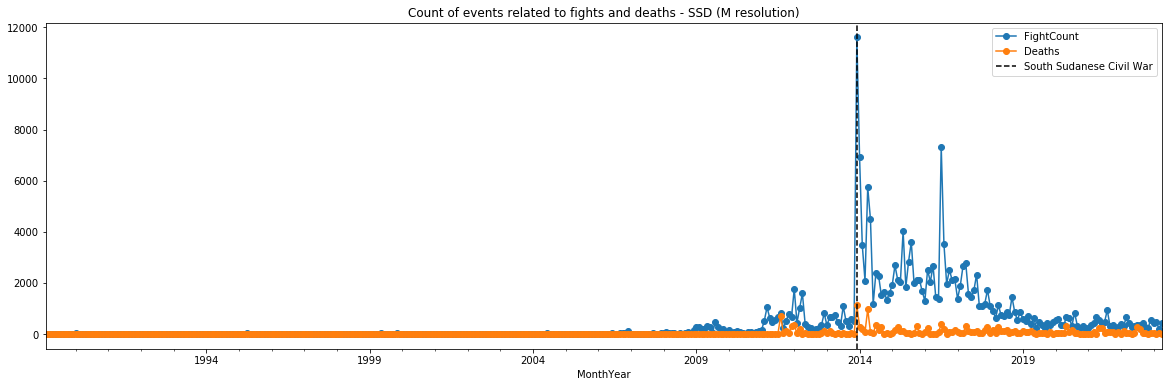

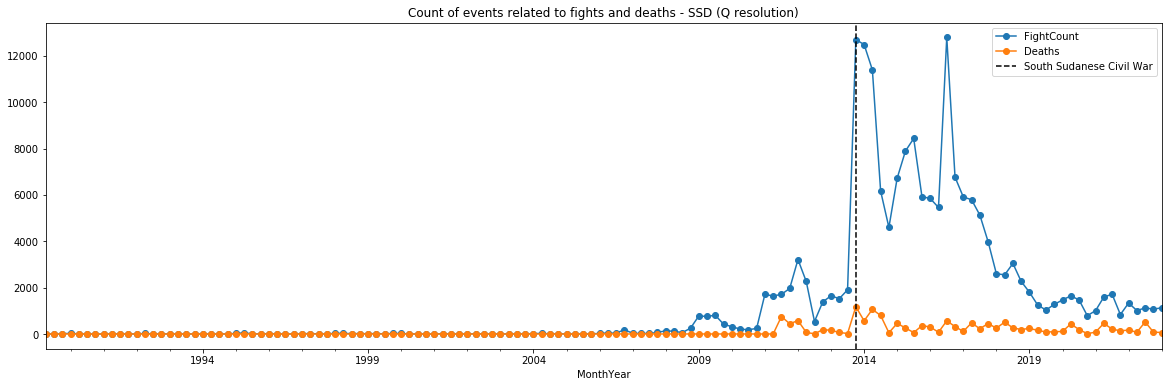

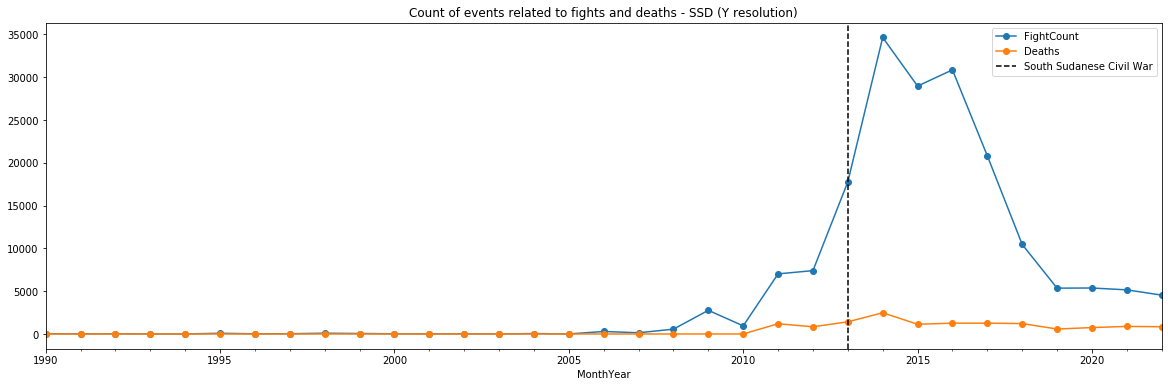

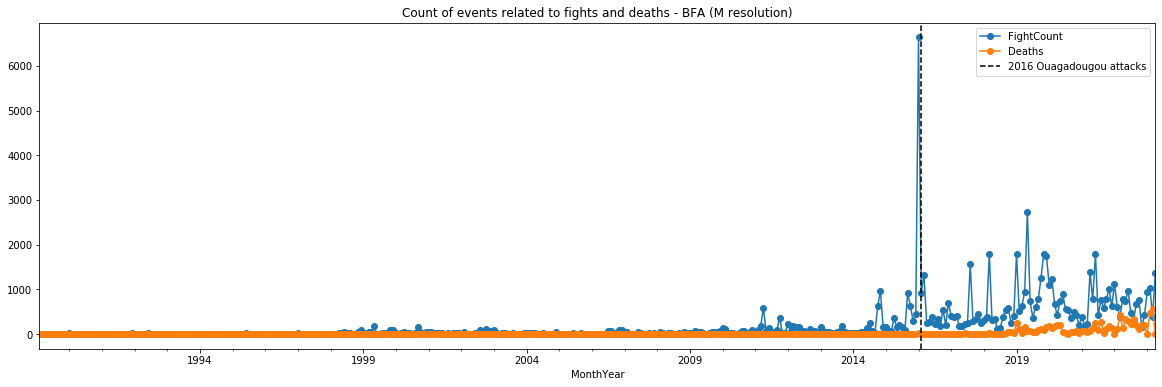

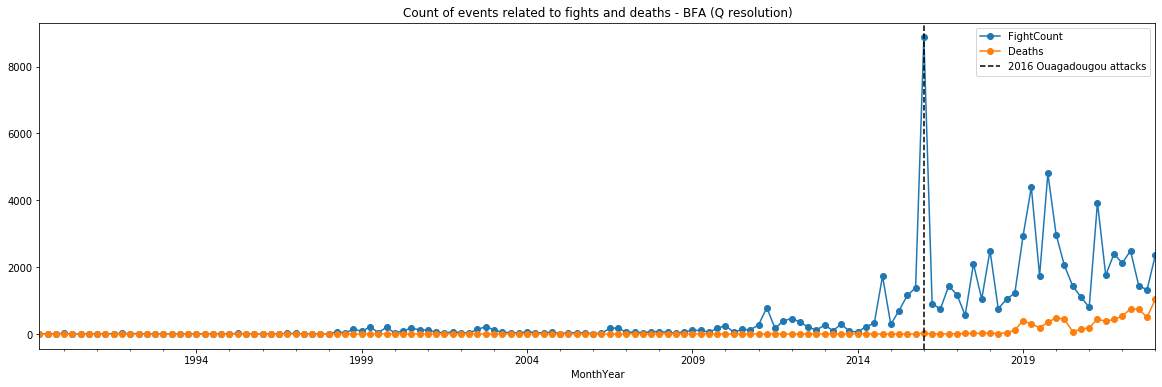

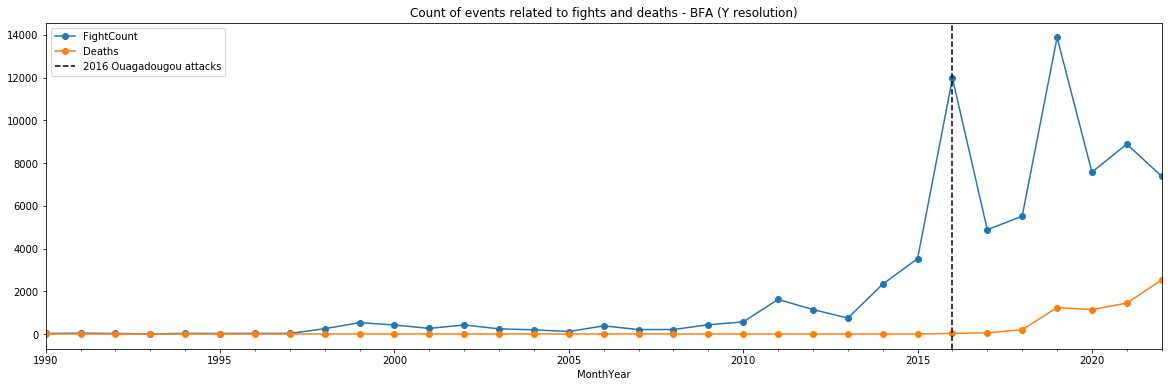

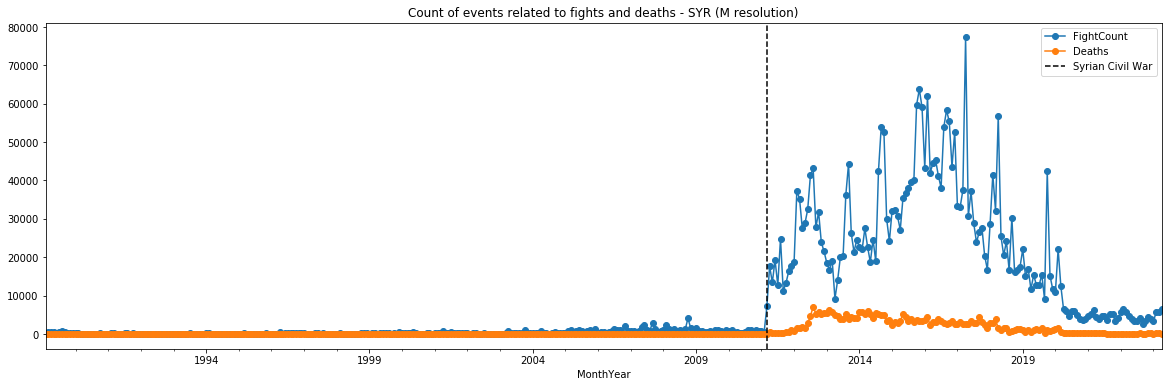

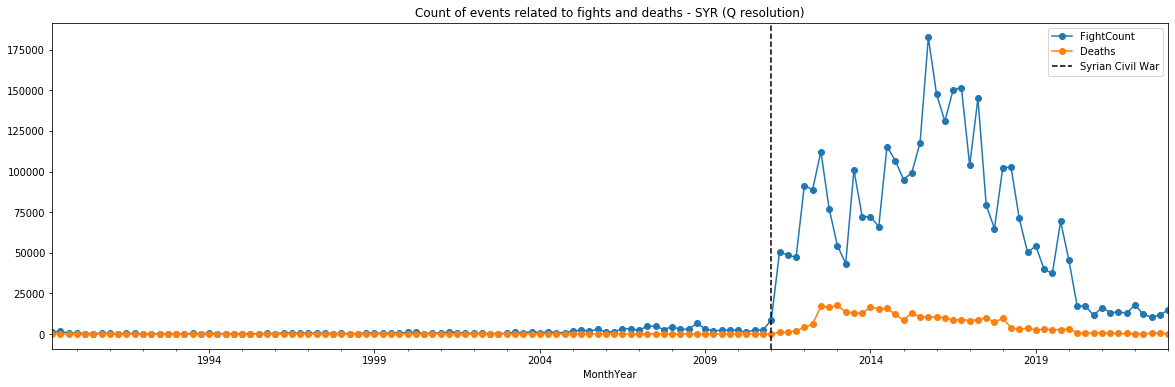

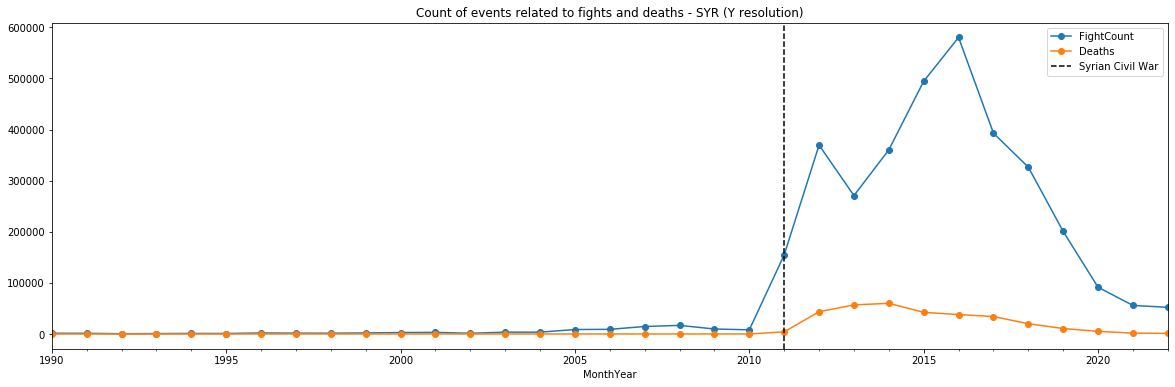

In [54]:
from matplotlib.lines import Line2D

# Create a list of countries to visualize event count distribution
countries = ['SSD', 'BFA', 'SYR']
highlight_dates = ['2013-12', '2016-02', '2011-03']
event_descriptions = ['South Sudanese Civil War', '2016 Ouagadougou attacks', 'Syrian Civil War']

for country, highlight_date, event_description in zip(countries, highlight_dates, event_descriptions):
    country_data = full[full.isocode == country]

    # Resample and plot the data
    for resolution in ['M', 'Q', 'Y']:
        fig, ax = plt.subplots(figsize=(20, 6))
        
        # Plot FightCount
        country_data.resample(resolution, on='MonthYear')['FightCount'].sum().iloc[1:-1].plot(ax=ax, marker='o', label='FightCount')
        
        # Plot deaths
        country_data.resample(resolution, on='MonthYear')['deaths'].sum().iloc[1:-1].plot(ax=ax, marker='o', label='Deaths')
        
        ax.set_title(f'Count of events related to fights and deaths - {country} ({resolution} resolution)')
        ax.legend()
        
        # Add vertical line for highlight date
        ax.axvline(pd.to_datetime(highlight_date), color='black', linestyle='--', label=event_description)
        
        # Create custom legend
        lines, labels = ax.get_legend_handles_labels()
        lines.append(Line2D([0], [0], color='red', linestyle='--'))
        ax.legend(lines, labels)
        
        plt.show()